# Yield-gap (maize) analysis and plotting for Africa

A quick analysis of yield-gaps and N2O emissions for Africa.

YG data: [source](http://www.earthstat.org/yield-gaps-climate-bins-major-crops/)

This notebook produces the summary figure for the publication.

Panels:  
- Yield gap
- N2O emissions
- N2O emissions YG-closed 50%
- N2O emissions YG-closed 75%
- N2O emissions vs yield-gap
- Yield-scaled N2O emissions



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import proplot as plot
import pandas as pd
import xarray as xr

In [3]:
ds = xr.open_dataset("yieldgap_maize_0083deg_v2.nc")
ds

<xarray.Dataset>
Dimensions:  (lat: 1080, lon: 1080)
Coordinates:
  * lat      (lat) float32 -49.9583 -49.875 -49.7917 ... 39.7917 39.875 39.9583
  * lon      (lon) float32 -29.9583 -29.875 -29.7917 ... 59.7917 59.875 59.9583
Data variables:
    ygap     (lat, lon) float32 ...
    mask     (lat, lon) bool ...
    ygapm    (lat, lon) float32 ...
    area     (lat, lon) float32 ...
    rot      (lat, lon) float64 ...
    country  (lat, lon) float64 ...

In [4]:
def yieldgap2emis(x, y0=0.158, a=1.196, b=0.322, rate=None):
    if rate:
        # x*(1-rate)
        return y0 + a*np.exp(-b* x*(1-rate))
    else:
        return y0 + a*np.exp(-b*x)

In [5]:
multipl = xr.where(ds.rot == 2, 2, 1)

In [6]:
ds["n2o_50p"] = yieldgap2emis(ds.ygapm, rate=0.50)
ds["n2o_75p"] = yieldgap2emis(ds.ygapm, rate=0.75)
ds["n2o_100p"] = yieldgap2emis(ds.ygapm, rate=1)
ds["n2o"] = yieldgap2emis(ds.ygapm, rate=0)

In [7]:
def preprocess_edgar_nc(da, convert_n2o_units=True):
    if convert_n2o_units:
        if da.units == 'kg m-2 s-1':
            # scale units and convert from N2O to N2O-N 
            da = da * 3600 * 24 * 365 * 10000 * (28/44)
            da.attrs['units'] = 'kg ha-1 yr-1'
        else:
            print('unexpected unit - no conversion')

    # also shift dataset from 0...360 longitude to -180...180
    da = da.assign_coords(lon=(((da.lon + 180) % 360) - 180)).sortby('lon')
    # make sure we have clean 2 digit lons
    da = da.assign_coords(lon=da.lon.round(2))
    da['lon'].attrs['long_name'] = 'longitude [degrees_east]'
    return da

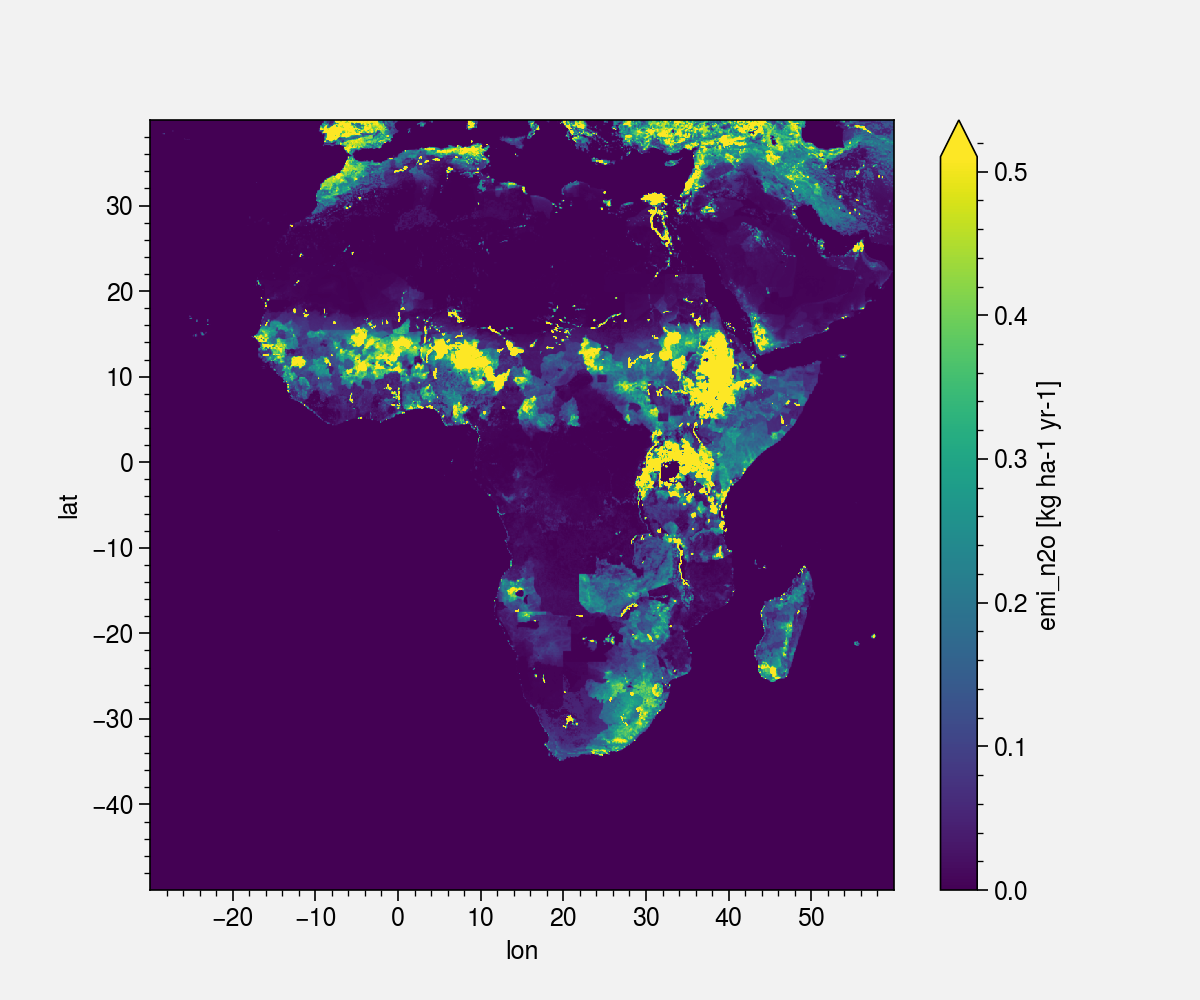

In [8]:
# EDGAR!
with xr.open_dataset("data/v50_N2O_2015_AGS.0.1x0.1.nc") as ds2:
    ds2 = preprocess_edgar_nc(ds2["emi_n2o"])
    ds2 = ds2.sel(lat=slice(-50, 40), lon=slice(-30,60))

    #interpolate into the higher resolution grid
    ds2 = ds2.interp(lat=ds.lat, lon=ds.lon)
    ds2.plot(figsize=(6,5), robust=True);

In [9]:
# read subsahara mask from edgar repo
with xr.open_dataset('data/mask.nc') as mask:
    ssa = mask.subsahara.interp(lat=ds.lat, lon=ds.lon)

In [10]:
# scatter plot data
df = pd.read_csv('data/input data_seasonal.csv')
df.columns = ['n2o', 'yieldscaled_n2o', 'yieldgap']

In [11]:
# confidence band data/ regression model 
df1 = pd.read_csv('data/confidence_bands_yieldgap_cumn2o.csv')
df2 = pd.read_csv('data/confidence_bands_yieldgap_ysemis.csv')
df1.head()

,x,y,lw_95c,up_95c,lw_95p,up_95p
0,0.281714,1.250428,0.949520,1.551336,0.581603,1.919253
1,0.315777,1.238523,0.946036,1.531010,0.573444,1.903602
2,0.349839,1.226748,0.942394,1.511102,0.565206,1.888291
3,0.383902,1.215101,0.938595,1.491608,0.556894,1.873309
4,0.417964,1.203582,0.934639,1.472525,0.548516,1.858648


In [12]:
colors = 'sunset'
colors_ls = 'marine' #'Purples' #'RdPu'
VMAX=3
LEVELS=[0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 2, 3]

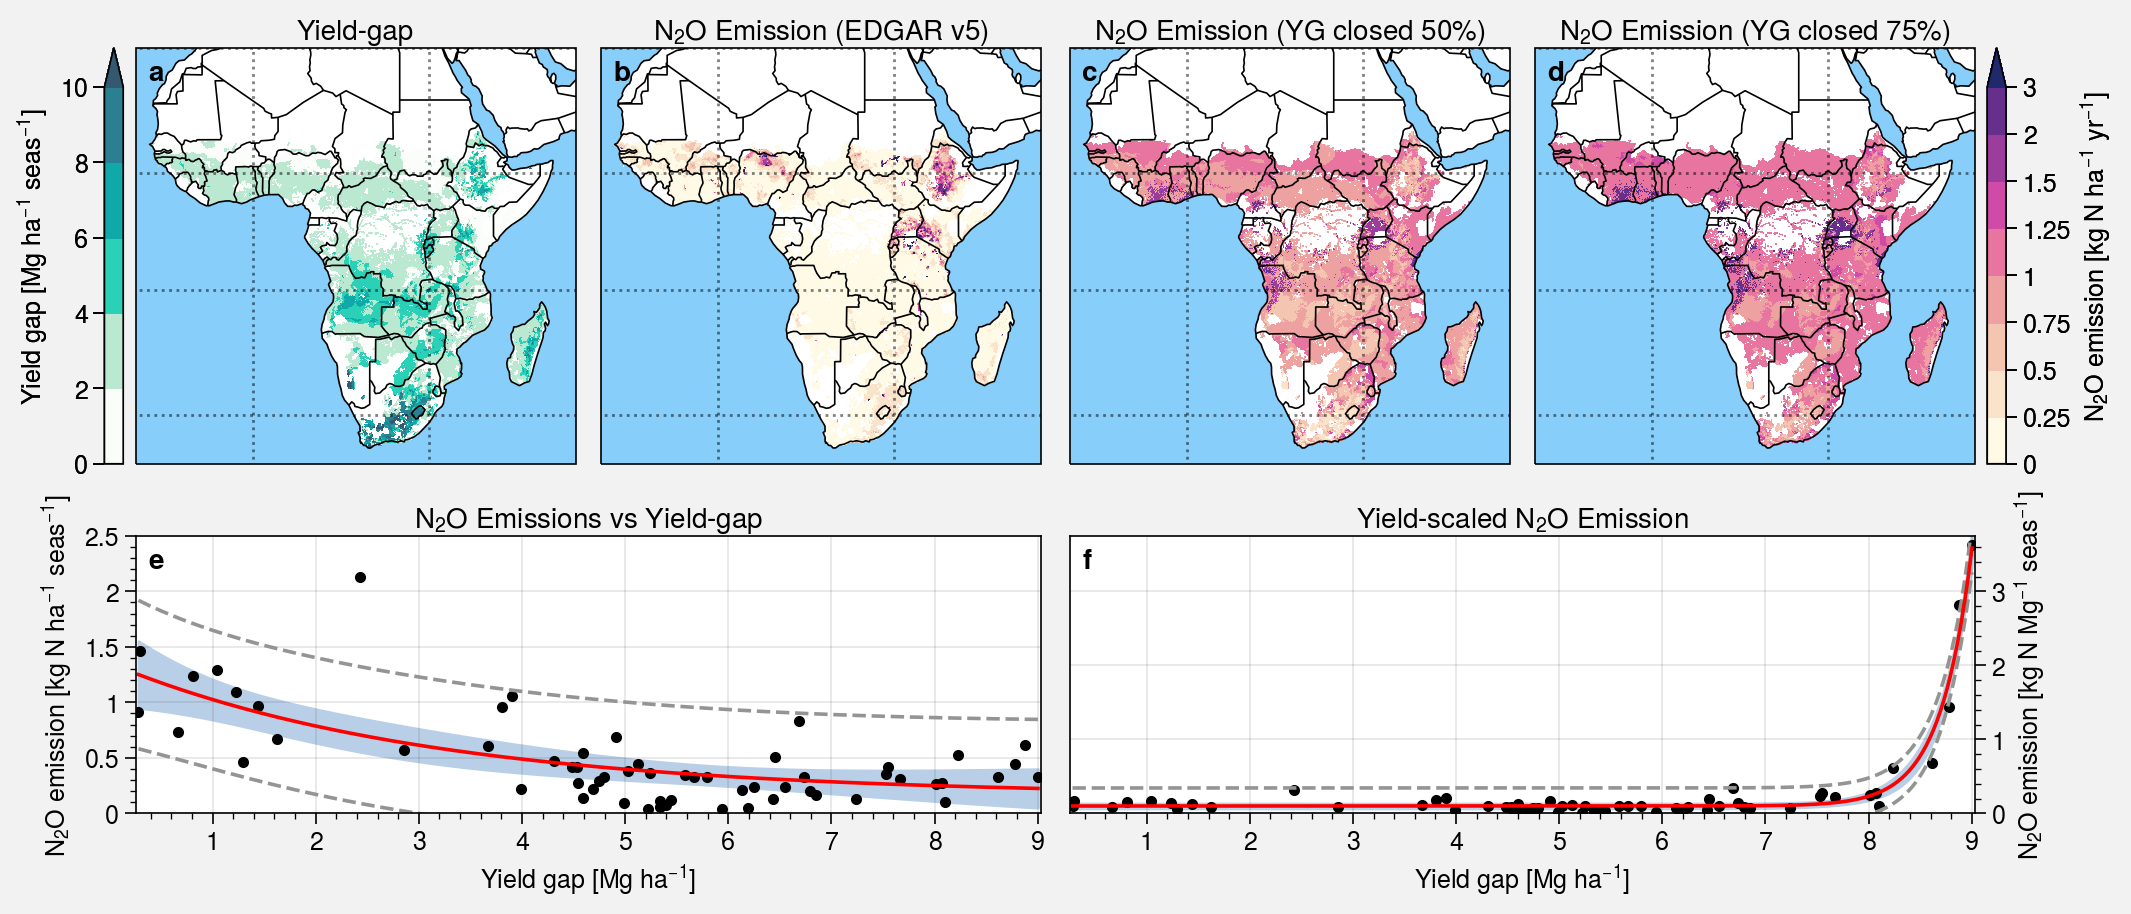

In [13]:
f, axs = plot.subplots([[1, 2, 3, 4], [5, 5, 6, 6]], 
                       hratios=(1.5, 1.),
                       axwidth=2.2,
                       share=0,
                       proj={k:'merc' for k in [1,2,3,4]}) #, share=3)


axs.format(abc=True, 
           abcloc='ul',
           abcborder=False)

# top row
for i, var in enumerate(['n2o', 'n2o_50p', 'n2o_75p']):
    m = axs[i+1].pcolormesh(
        (ds2 * ssa).where(ds[var] > -1) if var == 'n2o' else (ds[var]*multipl).where(ds[var] > -1) * ssa,
        cmap=colors,
        colorbar='r' if i==2 else None, 
        colorbar_kw={'label': 'N$_2$O emission [kg N ha$^{-1}$ yr$^{-1}$]', 'width': '0.75em'} if i==2 else None, 
        vmin=0, vmax=VMAX, levels=LEVELS,
        extend='max',
        linewidth=0.7, #color='gray7'
    )


# livestock units
axs[0].pcolormesh(
    ds.ygapm.where(ds.ygapm>-1), 
    cmap=colors_ls,
    colorbar='l', 
    linewidth=0.7,
    cmap_kw={'right': 0.8},
    colorbar_kw={'label': 'Yield gap [Mg ha$^{-1}$ seas$^{-1}$]', 'width': '0.75em'}, 
    vmin=0, vmax=12, levels=[0, 2, 4, 6, 8, 10],
    extend='max',
)

# scatter plots with uncertainties
axs[4].fill_between(df1.x, df1.lw_95c, df1.up_95c, color="#b9cfe7", edgecolor="", label='95% confidence')
axs[4].plot(df1.x, df1.lw_95p, linestyle='dashed', c='gray', label='95% pred. uncertainty')
axs[4].plot(df1.x, df1.up_95p, linestyle='dashed', c='gray')
axs[4].plot(df1.x, df1.y, c='red')
axs[4].scatter(df.yieldgap, df.n2o, c='black')

axs[5].fill_between(df2.x, df2.lw_95c, df2.up_95c, color="#b9cfe7", edgecolor="", label='95% confidence')
axs[5].plot(df2.x, df2.lw_95p, linestyle='dashed', c='gray', label='95% pred. uncertainty')
axs[5].plot(df2.x, df2.up_95p, linestyle='dashed', c='gray')
axs[5].plot(df2.x, df2.y, c='red')
axs[5].scatter(df.yieldgap, df.yieldscaled_n2o, c='black')

labels = ["Yield-gap", 
          "N$_2$O Emission (EDGAR v5)", 
          "N$_2$O Emission (YG closed 50%)", 
          "N$_2$O Emission (YG closed 75%)",
          "N$_2$O Emissions vs Yield-gap",
          "Yield-scaled N$_2$O Emission"]

# maps
for i in range(4):
    axs[i].format(
        title=labels[i],
        lonlim=(-20, 55), latlim=(-37, 30),
        borders=True,
        coast=True,
        ocean=True,
        oceancolor='lightskyblue',
    )

# data panels
for i in range(4, 6):
    axs[i].format(
        title=labels[i],
        ylim=(0, 3.75),
        xlabel='Yield gap [Mg ha$^{-1}$]'
    )

axs[4].format(ylabel='N$_2$O emission [kg N ha$^{-1}$ seas$^{-1}$]',
             ylim=(0, 2.5))
axs[5].format(ylabel='N$_2$O emission [kg N Mg$^{-1}$ seas$^{-1}$]',
              ytickloc='right',
              yticklabelloc='right')
    

In [14]:
f.savefig("panelplot_yieldgap_v2.png", dpi=400, facecolor='w')

## Extra analysis

In [15]:
tmw_lu = pd.read_csv('data/tmworld/tmworld_countries_lut.txt', delim_whitespace=True, header=None)
tmw_lu.columns = ['id', 'name']

lut = {k:v for k, v in zip(tmw_lu.id, tmw_lu.name)}

In [16]:
percountry = xr.Dataset()
for v in ["n2o", "n2o_50p", "n2o_75p"]:
    percountry[v] = (ds[v]*ssa).where(ds.n2o > -1).groupby(ds.country).mean()
percountry['edgar'] = (ds2 * ssa).where(ds.n2o > -1).groupby(ds.country).mean()
percountry = percountry.to_dataframe().reset_index()
percountry["country"] = percountry.country.astype('int')
percountry["cname"] = percountry.country.apply(lambda x: lut[x])
percountry['area_km2'] = (ds.area * ssa).where(ds.n2o > -1).groupby(ds.country).sum() * 0.01

percountry = percountry.dropna().drop('country', axis=1).round(3)
percountry['area_km2'] = percountry.area_km2.round(0).astype('int')
percountry = percountry[['cname', 'area_km2', 'edgar', 'n2o', 'n2o_50p', 'n2o_75p']]
percountry.head()

/Users/werner-ch/.pyenv/versions/miniconda3-latest/envs/datascience/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


,cname,area_km2,edgar,n2o,n2o_50p,n2o_75p
1,Angola,955234,0.034,0.492,0.776,1.013
2,Botswana,214254,0.051,0.522,0.809,1.037
3,Burundi,23755,0.425,0.419,0.701,0.958
4,Cameroon,222331,0.146,0.807,1.031,1.178
6,Central African Republic,437454,0.103,0.623,0.902,1.101


In [17]:
percountry.to_csv("n2o_perha_percountry.csv", index=False)

## Alternative plot... no edgar... just for reference

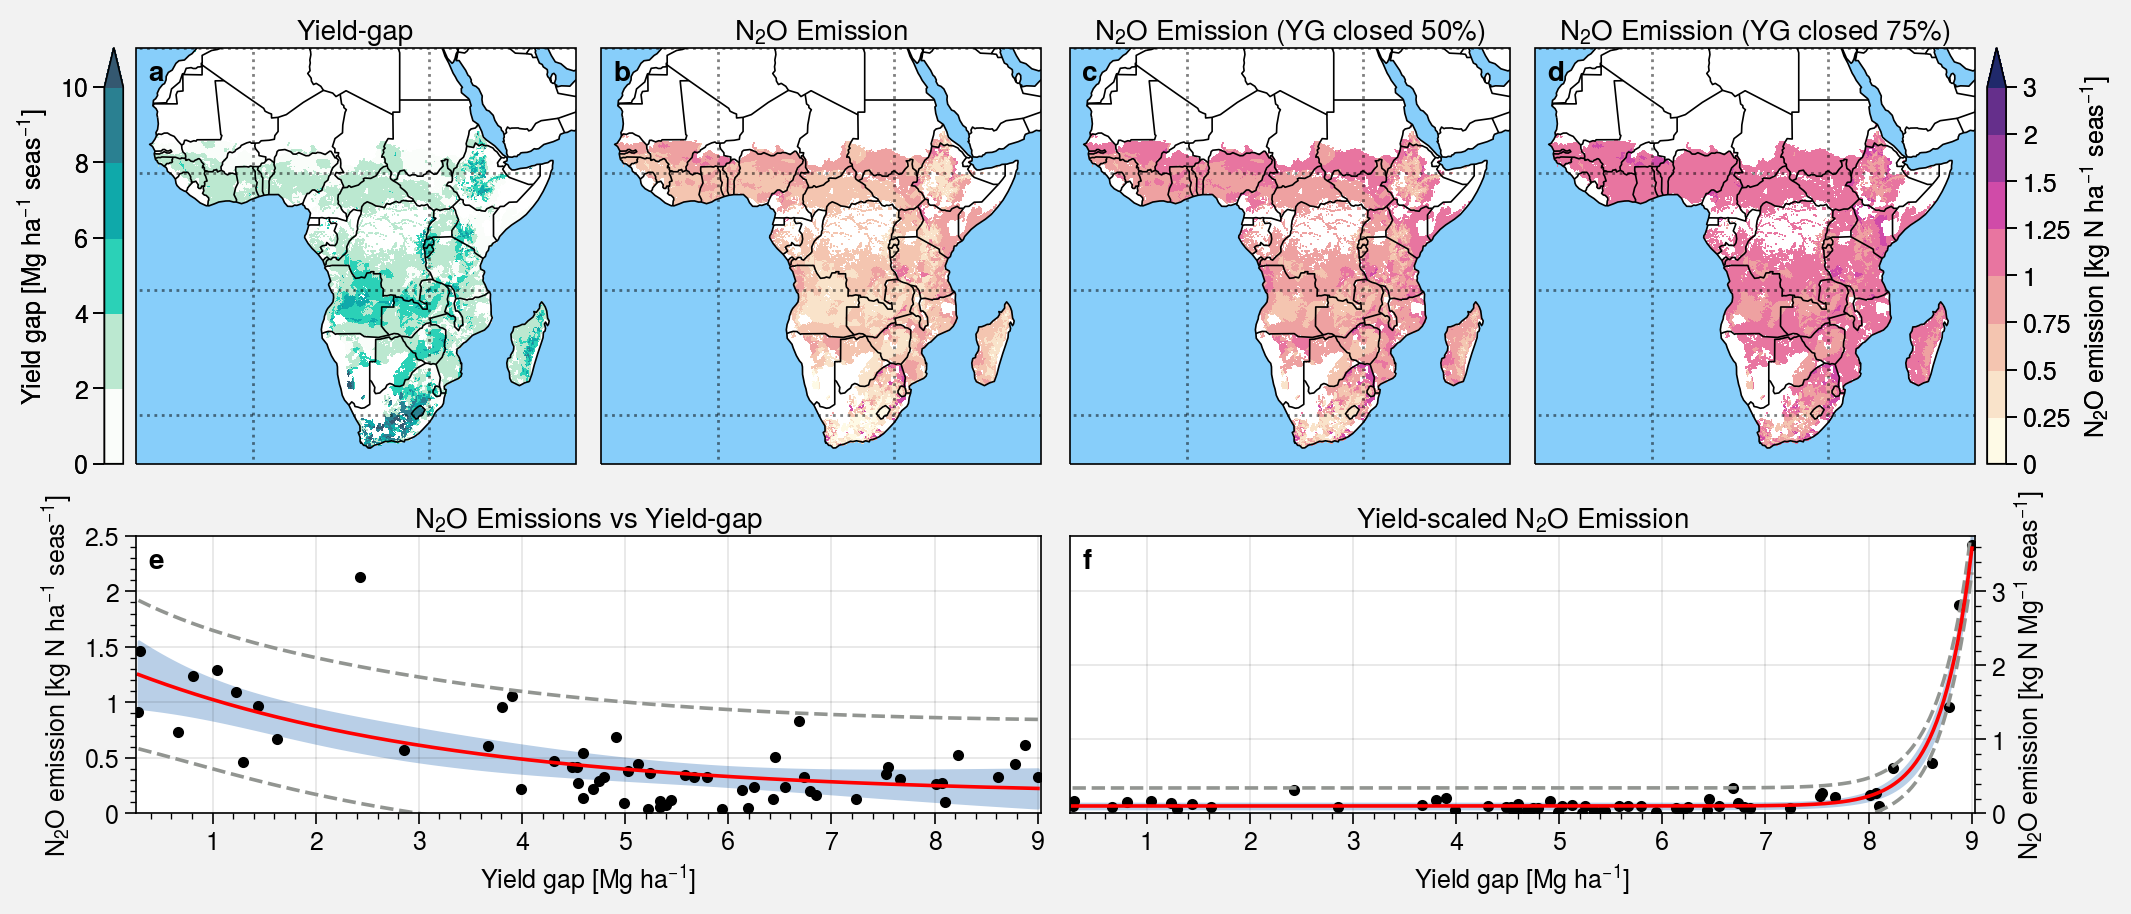

In [18]:
f, axs = plot.subplots([[1, 2, 3, 4], [5, 5, 6, 6]], 
                       hratios=(1.5, 1.),
                       axwidth=2.2,
                       share=0,
                       proj={k:'merc' for k in [1,2,3,4]}) #, share=3)


axs.format(abc=True, 
           abcloc='ul',
           abcborder=False)

# top row
for i, var in enumerate(['n2o', 'n2o_50p', 'n2o_75p']):
    m = axs[i+1].pcolormesh(
        #ds[var].where(ds[var] > -1),
        #(ds2 * 4/12. * ssa).where(ds[var] > -1) if var == 'n2o' else ds[var].where(ds[var] > -1) * ssa,
        ds[var].where(ds[var] > -1) * ssa,
        cmap=colors,
        colorbar='r' if i==2 else None, 
        colorbar_kw={'label': 'N$_2$O emission [kg N ha$^{-1}$ seas$^{-1}$]', 'width': '0.75em'} if i==2 else None, 
        vmin=0, vmax=VMAX, levels=LEVELS,
        extend='max',
        linewidth=0.7, #color='gray7'
    )


# livestock units
axs[0].pcolormesh(
    ds.ygapm.where(ds.ygapm>-1), 
    cmap=colors_ls,
    colorbar='l', 
    linewidth=0.7,
    cmap_kw={'right': 0.8},
    colorbar_kw={'label': 'Yield gap [Mg ha$^{-1}$ seas$^{-1}$]', 'width': '0.75em'}, 
    vmin=0, vmax=12, levels=[0, 2, 4, 6, 8, 10],
    extend='max',
)

# scatter plots with uncertainties
axs[4].fill_between(df1.x, df1.lw_95c, df1.up_95c, color="#b9cfe7", edgecolor="", label='95% confidence')
axs[4].plot(df1.x, df1.lw_95p, linestyle='dashed', c='gray', label='95% pred. uncertainty')
axs[4].plot(df1.x, df1.up_95p, linestyle='dashed', c='gray')
axs[4].plot(df1.x, df1.y, c='red')
axs[4].scatter(df.yieldgap, df.n2o, c='black')

axs[5].fill_between(df2.x, df2.lw_95c, df2.up_95c, color="#b9cfe7", edgecolor="", label='95% confidence')
axs[5].plot(df2.x, df2.lw_95p, linestyle='dashed', c='gray', label='95% pred. uncertainty')
axs[5].plot(df2.x, df2.up_95p, linestyle='dashed', c='gray')
axs[5].plot(df2.x, df2.y, c='red')
axs[5].scatter(df.yieldgap, df.yieldscaled_n2o, c='black')

labels = ["Yield-gap", 
          "N$_2$O Emission", 
          "N$_2$O Emission (YG closed 50%)", 
          "N$_2$O Emission (YG closed 75%)",
          "N$_2$O Emissions vs Yield-gap",
          "Yield-scaled N$_2$O Emission"]

# maps
for i in range(4):
    axs[i].format(
        title=labels[i],
        lonlim=(-20, 55), latlim=(-37, 30),
        borders=True,
        coast=True,
        ocean=True,
        oceancolor='lightskyblue',
    )

# data panels
for i in range(4, 6):
    axs[i].format(
        title=labels[i],
        ylim=(0, 3.75),
        xlabel='Yield gap [Mg ha$^{-1}$]'
    )

axs[4].format(ylabel='N$_2$O emission [kg N ha$^{-1}$ seas$^{-1}$]',
             ylim=(0, 2.5))
axs[5].format(ylabel='N$_2$O emission [kg N Mg$^{-1}$ seas$^{-1}$]',
              ytickloc='right',
              yticklabelloc='right')
    

In [19]:
f.savefig("panelplot_yieldgap_noedgar.png", dpi=400, facecolor='w')

In [20]:
ds

<xarray.Dataset>
Dimensions:   (lat: 1080, lon: 1080)
Coordinates:
  * lat       (lat) float32 -49.9583 -49.875 -49.7917 ... 39.7917 39.875 39.9583
  * lon       (lon) float32 -29.9583 -29.875 -29.7917 ... 59.7917 59.875 59.9583
Data variables:
    ygap      (lat, lon) float32 ...
    mask      (lat, lon) bool ...
    ygapm     (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    area      (lat, lon) float32 ...
    rot       (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    country   (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    n2o_50p   (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    n2o_75p   (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    n2o_100p  (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    n2o       (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan

# Stats

In [21]:
for var in ['n2o', 'n2o_50p', 'n2o_75p']:
    total = (ds[var].where(ds[var] > -1) * ssa * ds.area).sum().values
    total_area = (ds.area * ssa).sum().values * 0.01 * 10e-6
    print(f"{var}: {(total * 10e-6).round(1)}, {total_area.round(1)}, {(total*10e-6 / (total_area*100)).round(2)}")

total = ((ds2 * 4/12. * ssa).where(ds[var] > -1) * ssa * ds.area).sum().values
total_area = (ds.area * ssa).sum().values * 0.01 * 10e-6
print(f"edgar 4m: {(total * 10e-6).round(1)}, {total_area.round(1)}, {(total*10e-6 / (total_area*100)).round(2)}")

n2o: 7085.7, 238.2, 0.3
n2o_50p: 9932.0, 238.2, 0.42
n2o_75p: 12048.7, 238.2, 0.51
edgar 4m: 850.4, 238.2, 0.04


In [22]:
(ds[var].where(ds[var] > -1) * ssa * ds.area).sum().values

array(1.20486949e+09)

In [23]:
ds.area * ssa

<xarray.DataArray (lat: 1080, lon: 1080)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float32 -49.9583 -49.875 -49.7917 ... 39.7917 39.875 39.9583
  * lon      (lon) float32 -29.9583 -29.875 -29.7917 ... 59.7917 59.875 59.9583